# Lab 3: Bayes Classifier and Boosting

## Jupyter notebooks

In this lab, you can use Jupyter <https://jupyter.org/> to get a nice layout of your code and plots in one document. However, you may also use Python as usual, without Jupyter.

If you have Python and pip, you can install Jupyter with `sudo pip install jupyter`. Otherwise you can follow the instruction on <http://jupyter.readthedocs.org/en/latest/install.html>.

And that is everything you need! Now use a terminal to go into the folder with the provided lab files. Then run `jupyter notebook` to start a session in that folder. Click `lab3.ipynb` in the browser window that appeared to start this very notebook. You should click on the cells in order and either press `ctrl+enter` or `run cell` in the toolbar above to evaluate all the expressions.

Be sure to put `%matplotlib inline` at the top of every code cell where you call plotting functions to get the resulting plots inside the document.

## Import the libraries

In Jupyter, select the cell below and press `ctrl + enter` to import the needed libraries.
Check out `labfuns.py` if you are interested in the details.

In [73]:
import numpy as np
from scipy import misc
from imp import reload
from labfuns import *
from sklearn import decomposition
from matplotlib.colors import ColorConverter

# Miscelleneous Functions

In [74]:
# Tests if a matrix A is definite positive
def is_positive_definite(A):
    M = np.matrix(A)
    return np.all(np.linalg.eigvals(M+M.transpose()) > 0)

def set_Nan_to_zero(A):
    M = np.matrix(A)
    A[np.isnan(A)] = 0
    
def is_symmetric(A):
    M = np.matrix(A)
    return np.allclose(A.transpose(1, 0), A)
    
def convert_to_symmetric_positive_definite(A):
    vals, vecs = np.linalg.eigh(A)
    return A + vecs - 6 * np.identity

## Bayes classifier functions to implement

The lab descriptions state what each function should do.

In [187]:
# Note that you do not need to handle the W argument for this part
# in: labels - N x 1 vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels,W=None):
    # Your code here
    #### sort X by class
    classes = np.unique(labels)
    classesNo = classes.shape[0]
    dataNo = labels.shape[0]
    l = [[labels[i] for i in range(dataNo) if labels[i] == clas ] \
                     for clas in classes]
    prior = np.zeros(len(l))
    prior = [len(l[i])/dataNo for i in range(len(l))]
        
    return prior

# Note that you do not need to handle the W argument for this part
# in:      X - N x d matrix of N data points
#     labels - N x 1 vector of class labels
# out:    mu - C x d matrix of class means
#      sigma - d x d x C matrix of class covariances
def mlParams(X,labels,W=None):
    # Your code here
    classes = np.unique(labels)
    classesNo = classes.shape[0]
    dims = X.shape[1]
    dataNo = X.shape[0]
    mu = np.zeros((classesNo, dims));
    sigma = np.zeros((dims, dims, classesNo))
    
    #### sort X by class
    Xk = np.asarray([[X[i] for i in range(dataNo) if labels[i] == clas ] \
                     for clas in classes])
    mu = np.mean(Xk, axis = 1)
    
    #### center X
    Xc = np.asarray([np.subtract(X[i], mu[c, :]) for c in classes for i in range(dataNo) if labels[i] == c ])
    
    #### center Xk sorted by class
    Xkc = np.asarray([np.subtract(Xk[c,i,:], mu[c, :]) for c in classes for i in range(Xk.shape[1])])
    
    #### sort Xc centered by category
    Xck = np.asarray([[Xc[i] for i in range(dataNo) if labels[i] == clas ] \
                     for clas in classes])
    
    #### 
    #s = np.asarray(np.mean(np.outer(Xck[c,i,:], Xck[c, i, :])   \
    #                     for i in range(Xck.shape[1]) for c in classes ], axis = (0)))
    s = np.zeros((dims,dims))

    for c in range(Xck.shape[0]):
        count = 0
        for i in range(dataNo):
            if(labels[i]==classes[c]):
                s = np.add(s, np.outer(Xc[i,:], Xc[i, :]))
                count +=1
                #print(count)
        s/=count;
        sigma[:, :, c] = s
        #sigma[:,:,c]
    
    #z=np.asarray([np.asarray(np.outer(Xc[i], Xc[i])) for i in range(dataNo)])
    #sigma = np.asarray(np.sum([np.outer(Xc[i], Xc[i])   \
    #                     for i in range(dataNo) for c in classes if labels[i] == c  ], axis = (0,2)))
    #print("sigma shape ", sigma.shape)

    #sigma = np.asarray([np.mean([np.dot(np.transpose(Xc[i]), Xc[i])  for c in classes ], axis = 0) \
    #                    for i in range(dataNo) ])
    
    #pass
    return mu, sigma

def computeY(cls, x, mu, sigma, covdiag = True):
    L = np.zeros(sigma.shape)
    x = 0
    if covdiag:
        sigma = np.diag(np.diag(sigma))
        try:
            sigmaInv = np.linalg.inv(sigma)
#             print("Inverse found")
            L = sigmaInv
            b = np.transpose(np.subtract(x, mu))
            x = np.dot(L, b)
        except np.linalg.LinAlgError:
            # Not invertible. Skip this one.
#             print(sigma)
#             print("No inverse")
            A = sigma[:,:]
            b = np.transpose(np.subtract(x, mu))
            L = np.linalg.cholesky(A)
            y = np.linalg.solve(L,b)
            x = np.linalg.solve(L.getH(),y)
            pass
#         else:
            # continue with what you were doing
            
            
    else:
        A = sigma[:,:]
        b = np.transpose(np.subtract(x, mu))
        L = np.linalg.cholesky(A)
        y = np.linalg.solve(L,b)
        x = np.linalg.solve(L.getH(),y)
#     print("L ")
#     print(L.shape)
#     print(type(L))
#     print("x ")
#     print(x.shape)
#     print(type(x))
    return L, np.transpose(x)

# in:      X - N x d matrix of M data points
#      prior - C x 1 vector of class priors
#         mu - C x d matrix of class means
#      sigma - d x d x C matrix of class covariances
# out:     h - N x 1 class predictions for test points
def classify(X,prior,mu,sigma,covdiag=True):
    # Your code here
    # Example code for solving a psd system
    priors = computePrior(labels)
    logPosteriors = np.zeros((sigma.shape[2], X.shape[0]))

    for i in range(X.shape[0]):
        for cls in range(sigma.shape[2]):
            if is_symmetric(sigma[:, :, cls]) and is_positive_definite(sigma[:, :, cls]):
                L, y = computeY(cls, X[i], mu[cls], sigma[:, :, cls])
                logPosteriors[cls, i] = computeLogPosterior(X[i], cls, \
                                                            priors[cls], \
                                                    mu[cls], sigma[:, :, cls], L, y)
                
            
        
#     values = np.asarray(
#         [[computeLogPosterior(x, cls, prior[cls], mu[cls], sigma[cls], sigmaInv[cls]) \
#           for cls in classes] for x in X])
    h = np.max(logPosteriors, axis = 0)
#     print(h)
    return h

# in:      x - 1 x d vector of 1 data point to be classified
#      class - class number
#      prior - C x 1 vector of class priors
#         mu - C x d matrix of class means
#      sigma - d x d x C matrix of class covariances
# out:     h - N x 1 class predictions for test points
def computeLogPosterior(x, cls, prior,mu,sigma, L, y):
    lnl = 2 * np.sum(np.diagonal(np.log(L)))
    logPosterior = \
        -1/2 * lnl \
        - 1/2 * np.dot(np.subtract(x, mu), y) \
        + np.log(prior)
        
#         - 1/2 * np.dot(np.subtract(x, mu), y) \
    
#     print(type(y))
#     print(type(np.subtract(x, mu)))
#     print("type of multiplication")
#     print((np.subtract(x, mu) * y).shape)
#     print(type(np.subtract(x, mu) * y))
    return logPosterior

## Test the Maximum Likelihood estimates

Call `genBlobs` and `plotGaussian` to verify your estimates.

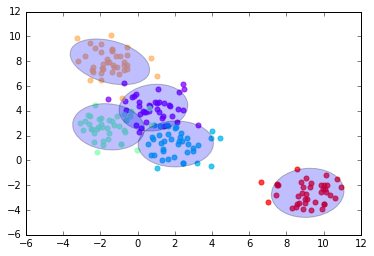

In [97]:
%matplotlib inline

X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)

## Boosting functions to implement

The lab descriptions state what each function should do.

In [98]:
# in:       X - N x d matrix of N data points
#      labels - N x 1 vector of class labels
#           T - number of boosting iterations
# out: priors - length T list of prior as above
#         mus - length T list of mu as above
#      sigmas - length T list of sigma as above
#      alphas - T x 1 vector of vote weights 
def trainBoost(X,labels,T=5,covdiag=True):
    # Your code here
    return priors,mus,sigmas,alphas

# in:       X - N x d matrix of N data points
#      priors - length T list of prior as above
#         mus - length T list of mu as above
#      sigmas - length T list of sigma as above
#      alphas - T x 1 vector of vote weights
# out:  yPred - N x 1 class predictions for test points
def classifyBoost(X,priors,mus,sigmas,alphas,covdiag=True):
    # Your code here
    return c

## Define our testing function

The function below, `testClassifier`, will be used to try out the different datasets. `fetchDataset` can be provided with any of the dataset arguments `wine`, `iris`, `olivetti` and `vowel`. Observe that we split the data into a **training** and a **testing** set.

In [99]:
np.set_printoptions(threshold=np.nan)
np.set_printoptions(precision=25)
np.set_printoptions(linewidth=200)

def testClassifier(dataset='iris',dim=0,split=0.7,doboost=False,boostiter=5,covdiag=True,ntrials=100):

    X,y,pcadim = fetchDataset(dataset)

    means = np.zeros(ntrials,);

    for trial in range(ntrials):

        # xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplit(X,y,split)
        xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,split)

        # Do PCA replace default value if user provides it 
        if dim > 0:
            pcadim = dim
        if pcadim > 0:     
            pca = decomposition.PCA(n_components=pcadim)
            pca.fit(xTr)
            xTr = pca.transform(xTr)
            xTe = pca.transform(xTe)     

        ## Boosting  
        if doboost:
            # Compute params
            priors,mus,sigmas,alphas = trainBoost(xTr,yTr,T=boostiter,covdiag=covdiag)
            yPr = classifyBoost(xTe,priors,mus,sigmas,alphas)        
        else:
        ## Simple
            # Compute params
            prior = computePrior(yTr)
            mu, sigma = mlParams(xTr,yTr)
            # Predict
            yPr = classify(xTe,prior,mu,sigma,covdiag=covdiag)

        # Compute classification error
        print("Trial:",trial,"Accuracy",100*np.mean((yPr==yTe).astype(float)))

        means[trial] = 100*np.mean((yPr==yTe).astype(float))

    print("Final mean classification accuracy ", np.mean(means), "with standard deviation", np.std(means))

## Plotting the decision boundary

This is some code that you can use for plotting the decision boundary
boundary in the last part of the lab.

In [100]:
def plotBoundary(dataset='iris',split=0.7,doboost=False,boostiter=5,covdiag=True):
    
    X,y,pcadim = fetchDataset(dataset)
    xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,split)
    pca = decomposition.PCA(n_components=2)
    pca.fit(xTr)
    xTr = pca.transform(xTr)
    xTe = pca.transform(xTe)
    
    pX = np.vstack((xTr, xTe))
    py = np.hstack((yTr, yTe))
     
    if doboost:
        ## Boosting
        # Compute params
        priors,mus,sigmas,alphas = trainBoost(xTr,yTr,T=boostiter,covdiag=covdiag)       
    else:
        ## Simple
        # Compute params
        prior = computePrior(yTr)
        mu, sigma = mlParams(xTr,yTr)

    xRange = np.arange(np.min(pX[:,0]),np.max(pX[:,0]),np.abs(np.max(pX[:,0])-np.min(pX[:,0]))/100.0)
    yRange = np.arange(np.min(pX[:,1]),np.max(pX[:,1]),np.abs(np.max(pX[:,1])-np.min(pX[:,1]))/100.0)

    grid = np.zeros((yRange.size, xRange.size))
    
    for (xi, xx) in enumerate(xRange):
        for (yi, yy) in enumerate(yRange):
            if doboost:
                ## Boosting 
                grid[yi,xi] = classifyBoost(np.matrix([[xx, yy]]),priors,mus,sigmas,alphas,covdiag=covdiag)        
            else:
                ## Simple
                grid[yi,xi] = classify(np.matrix([[xx, yy]]),prior,mu,sigma,covdiag=covdiag)
    
    classes = range(np.min(y), np.max(y)+1)
    ys = [i+xx+(i*xx)**2 for i in range(len(classes))]
    colormap = cm.rainbow(np.linspace(0, 1, len(ys)))

    plt.hold(True)
    conv = ColorConverter()
    for (color, c) in zip(colormap, classes):
        try:
            CS = plt.contour(xRange,yRange,(grid==c).astype(float),15,linewidths=0.25,colors=conv.to_rgba_array(color))
        except ValueError:
            pass
        xc = pX[py == c, :]
        plt.scatter(xc[:,0],xc[:,1],marker='o',c=color,s=40,alpha=0.5)
        
    plt.xlim(np.min(pX[:,0]),np.max(pX[:,0]))
    plt.ylim(np.min(pX[:,1]),np.max(pX[:,1]))
    plt.show()

## Run some experiments

Call the `testClassifier` and `plotBoundary` functions for this part.

d:\Anaconda3\envs\dd2431_ml_lab3\lib\site-packages\ipykernel\__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
d:\Anaconda3\envs\dd2431_ml_lab3\lib\site-packages\ipykernel\__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
d:\Anaconda3\envs\dd2431_ml_lab3\lib\site-packages\ipykernel\__main__.py:142: RuntimeWarning: divide by zero encountered in log


Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Inverse found
Invers

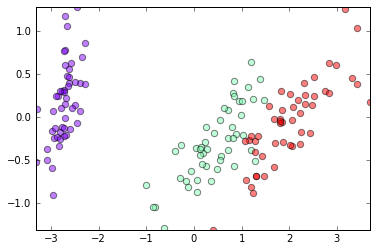

In [186]:
%matplotlib inline

# Example usage of the functions

testClassifier(dataset='iris',split=0.7,doboost=False,boostiter=5,covdiag=True)
plotBoundary(dataset='iris',split=0.7,doboost=False,boostiter=5,covdiag=True)

# Answers

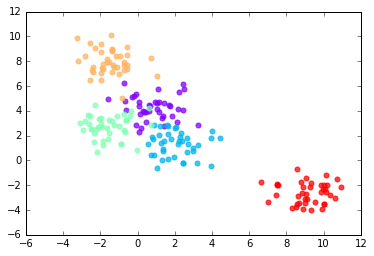

In [102]:
X, labels = genBlobs();
plotGaussianNoEllipses(X, labels)

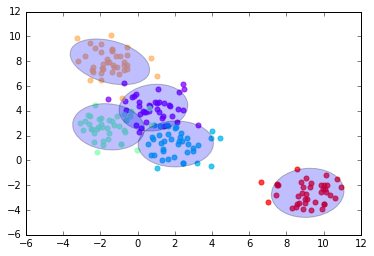

In [103]:
mu, sigma = mlParams(X, labels)
plotGaussian(X, labels, mu, sigma)

In [104]:
computePrior(labels)

[0.2, 0.2, 0.2, 0.2, 0.2]

[[1 2]
 [3 4]]
[[1 2]
 [3 4]]
